This is a kernel to make classifier of 'NORMAL' or 'PNEUMONIA'.

I do transfer learning and finetuning. It's based on vgg16 model and replace output layer for 2 classes classifier.
I apply finetuning to its parameters.

I import PyTorch to do deep learning. Pretrained model is from PyTorch library.
Following script is not so complex, but the result is not bad.

I frequently insert simple comments. I hope this kernel is useful for PyTorch deep learning beginner.

In [1]:
# import packages
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

As the preprocess, I do random crop and color normalization for training data.

Chest X-ray images are taken from almost same angle. So preprocess is not so difficult.

One pneumonia example before and after preprocess is shown. 

In 'PNEUMONIA' image, There is white area (seems pneumonia area), so it tends to be emphasized.
On the other hand, in 'NOMAL' image, ribs are clearly shown.

In [2]:
# setting random number seed. Arbitrary seed is OK.
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# preprocess class for each image
class ImageTransform():

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # data augmentation
                transforms.RandomResizedCrop(
                   resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(), 
                # convert to tensor for PyTorch
                transforms.ToTensor(),
                # color normalization
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):

        return self.data_transform[phase](img)



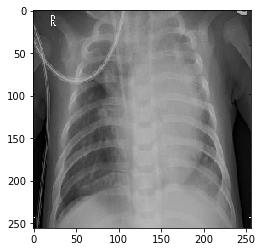

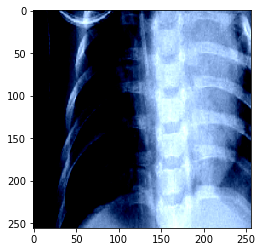

In [3]:
# Showing one result of the preprocess

image_file_path = '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg'

img_originalsize = Image.open(image_file_path)   # [height][width][color RGB]
img = img_originalsize.resize((256, 256))

img = img.convert("L").convert("RGB")

# original image
plt.imshow(img)
plt.show()

# after preprocess
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (color, height, width) -> (height, width, color), normalize colors in the range (0 - 1)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


For PyTorch dataloader, I prepare file path list and dataset.

Labels are made from file path. For PyTorch beginner, motion check raws are useful to debug.

In [4]:
# making file path list
def make_datapath_list(phase="train"):
    
    rootpath = "../input/chest-xray-pneumonia/chest_xray/"
    
    target_path = osp.join(rootpath+phase+'/**/*.jpeg')
    print(target_path)

    path_list = []

    # getting file paths
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg
../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg


In [5]:
# making dataset

class lungDataset(data.Dataset):

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):

        # load image
        img_path = self.file_list[index]
        
        img_originalsize = Image.open(img_path)
        # resize
        img = img_originalsize.resize((256, 256))
        
        # grey -> color
        img = img.convert("L").convert("RGB")

        # preprocess
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # picking up labels
        if self.phase == "train":
            label = img_path[47:53]

        elif self.phase == "val":
            label = img_path[45:51]

        # label char -> number
        if label == "NORMAL":
            label = 0

        elif label == "PNEUMO":
            label = 1

        return img_transformed, label


# run
train_dataset = lungDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = lungDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# motion check
# index = 0
# print(train_dataset.__getitem__(index)[0].size())
# print(train_dataset.__getitem__(index)[1])

# print(val_dataset.__getitem__(index)[0].size())
# print(val_dataset.__getitem__(index)[1])


PyTorch dataloader needs dataset includinig label and data itself.

In the training phase, dataloader provide 'batch_size' data automatically.

In [6]:
batch_size = 32

# making dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# put dataloader into dictionary type
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# motion check
# batch_iterator = iter(dataloaders_dict["train"])

# inputs, labels = next(
#     batch_iterator)  # pick up first element
# print(inputs.size())
# print(labels)


In [7]:
# load pretrained vgg16 from PyTorch as an instance
# need to make setting 'internet' to 'On'.
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replace output layer for 2 class classifier, 'NORMAL' and 'PNEUMONIA'.
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
# setting of loss function
criterion = nn.CrossEntropyLoss()

# setting fine tuned parameters

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Not only output layer, "features" layers and other classifier layers are tuned.
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# store parameters in list
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        #print("params_to_update_1:", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        #print("params_to_update_2:", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        #print("params_to_update_3:", name)

    else:
        param.requires_grad = False
        #print("no learning", name)

# print("-----------")
# print(params_to_update_1)

# Learning Rates
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)


In folowing training function, 'training_model', have accuracy_list and losslist.
They are for plot learing model in later phase.

In [9]:
# training function
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    accuracy_list = []
    loss_list = []
    
    # Precondition : Accelerator GPU -> 'On'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using device：", device)

    # put betwork into GPU
    net.to(device)
    torch.backends.cudnn.benchmark = True

    # epoch loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # set network 'train' mode
            else:
                net.eval()   # set network 'val' mode

            epoch_loss = 0.0
            epoch_corrects = 0

            # Before training
            if (epoch == 0) and (phase == 'train'):
                continue
            
                      
            # batch loop
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                   
                # send data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # initialize optimizer
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)

                    loss = criterion(outputs, labels)  #calcurate loss
                    _, preds = torch.max(outputs, 1)  # predict
  
                    # back propagtion
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # update loss summation
                    epoch_loss += loss.item() * inputs.size(0)  
                    # update correct prediction summation
                    epoch_corrects += torch.sum(preds == labels.data)

            # loss and accuracy for each epoch loop
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                accuracy_list.append(epoch_acc.item())
                loss_list.append(epoch_loss)
            
    return accuracy_list, loss_list


In [10]:
# start training
num_epochs=10
accuracy_list, loss_list = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

using device： cuda:0


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/10
-------------


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.6327 Acc: 0.7500
Epoch 2/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2506 Acc: 0.8917


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.3351 Acc: 0.8125
Epoch 3/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1221 Acc: 0.9549


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.2678 Acc: 0.8750
Epoch 4/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0976 Acc: 0.9632


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.1125 Acc: 1.0000
Epoch 5/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0937 Acc: 0.9659


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.1534 Acc: 0.8750
Epoch 6/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0801 Acc: 0.9714


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.1049 Acc: 0.9375
Epoch 7/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0728 Acc: 0.9726


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.1698 Acc: 0.9375
Epoch 8/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0685 Acc: 0.9751


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.1574 Acc: 0.8750
Epoch 9/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0736 Acc: 0.9728


  0%|          | 0/163 [00:00<?, ?it/s]

val Loss: 0.0986 Acc: 1.0000
Epoch 10/10
-------------


  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0646 Acc: 0.9770


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

val Loss: 0.0721 Acc: 1.0000


In [11]:
# To save trained model
# save_path = './weights_fine_tuning.pth'
# torch.save(net.state_dict(), save_path)


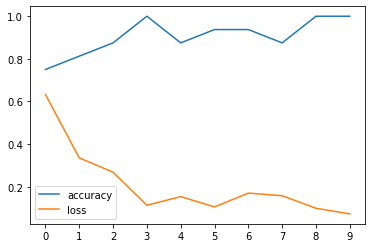

In [12]:
epoch_num = list(range(10))
fig, ax = plt.subplots(facecolor="w")
ax.plot(epoch_num, accuracy_list, label="accuracy")
ax.plot(epoch_num, loss_list, label="loss")
plt.xticks(epoch_num) 

ax.legend()

plt.show()

To avoid over learning, I think that around epoch 5~6 may be good model. Train accuracy will be better for a while. But validation accuracy keep around 90%.

In this time, I used common technics but accuray is not bad.
Honestly, it's my first submission and first try of PyTorch. I leave behind motion check and comments.

I hope they are useful for beginners.

I refer to 

'つくりながら学ぶ！　PyTorchによる発展ディープラーニング　株式会社マイナビ出版'
ISBN:978-4-8399-7025-3